In [34]:
import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import make_dot
from sklearn.linear_model import Ridge, LinearRegression
import networkx as nx
import pydotplus
import datetime

from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.importer.xes import importer as xes_importer

# process mining 
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery

# viz
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
from pm4py.visualization.dfg import visualizer as dfg_visualization

# misc 
from pm4py.objects.conversion.process_tree import converter as pt_converter

In [35]:
import xml.etree.ElementTree as Xet
import pandas as pd

### our LiNGAM

In [36]:
#Run prior to actual algorithm runs - this is the definition of the alg
import graphviz
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import LassoLarsIC
from sklearn.utils import check_array

import igraph as ig
from scipy.special import expit as sigmoid
import random


__all__ = [
    "print_causal_directions",
    "print_dagc",
    "make_prior_knowledge",
    "remove_effect",
    "make_dot",
    "predict_adaptive_lasso",
    "get_sink_variables",
    "get_exo_variables",
    "find_all_paths",
    "simulate_dag",
    "simulate_parameter",
    "simulate_linear_sem",
    "count_accuracy",
    "set_random_seed",
]


def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)


def simulate_linear_sem(adjacency_matrix, n_samples, sem_type, noise_scale=1.0):
    """Simulate samples from linear SEM with specified type of noise.
    Parameters
    ----------
    adjacency_matrix : array-like, shape (n_features, n_features)
        Weighted adjacency matrix of DAG, where ``n_features``
        is the number of variables.
    n_samples : int
        Number of samples. n_samples=inf mimics population risk.
    sem_type : str
        SEM type. gauss, exp, gumbel, logistic, poisson.
    noise_scale : float
        scale parameter of additive noise.
    Returns
    -------
    X : array-like, shape (n_samples, n_features)
        Data generated from linear SEM with specified type of noise,
        where ``n_features`` is the number of variables.
    """
    def _simulate_single_equation(X, w):
        """Simulate samples from a single equation.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features_parents)
            Data of parents for a specified variable, where
            n_features_parents is the number of parents.
        w : array-like, shape (1, n_features_parents)
            Weights of parents.
        Returns
        -------
        x : array-like, shape (n_samples, 1)
            Data for the specified variable.
        """
        if sem_type == 'gauss':
            z = np.random.normal(scale=noise_scale, size=n_samples)
            x = X @ w + z
        elif sem_type == 'exp':
            z = np.random.exponential(scale=noise_scale, size=n_samples)
            x = X @ w + z
        elif sem_type == 'gumbel':
            z = np.random.gumbel(scale=noise_scale, size=n_samples)
            x = X @ w + z
        elif sem_type == 'logistic':
            x = np.random.binomial(1, sigmoid(X @ w)) * 1.0
        elif sem_type == 'poisson':
            x = np.random.poisson(np.exp(X @ w)) * 1.0
        elif sem_type == 'subGaussian':
            z = np.random.normal(scale=noise_scale, size=n_samples)
            q = 0.5 + 0.3 * np.random.rand(1)  # sub-Gaussian
            z = np.sign(z) * pow(np.abs(z), q)
            z = z - np.mean(z)
            z = z / np.std(z)
            x = X @ w + z
        elif sem_type == 'supGaussian':
            z = np.random.normal(scale=noise_scale, size=n_samples)
            q = 1.2 + 0.8 * np.random.rand(1)  # super-Gaussian
            z = np.sign(z) * pow(np.abs(z), q)
            z = z - np.mean(z)
            z = z / np.std(z)
            x = X @ w + z
        elif sem_type == 'nonGaussian':
            z = np.random.normal(scale=noise_scale, size=n_samples)
            qq = -1
            if qq == 1:
                q = 0.5 + 0.3 * np.random.rand(1)  # sub-Gaussian
            else:
                q = 1.2 + 0.8 * np.random.rand(1)  # super-Gaussian
            z = np.sign(z) * pow(np.abs(z), q)
            z = z - np.mean(z)
            z = z / np.std(z)
            x = X @ w + z
        elif sem_type == 'uniform':
            z = np.random.uniform(0, 1, n_samples)
            z = z - np.mean(z)
            z = z / np.std(z)
            x = X @ w + z
        elif sem_type == 'gamma':
            z = np.random.gamma(2, 2, n_samples)
            z = z - np.mean(z)
            z = z / np.std(z)
            x = X @ w + z
        elif sem_type == 'laplace':
            z = np.random.laplace(0, scale=noise_scale, size=n_samples)
            x = X @ w + z
        else:
            raise ValueError('unknown sem type')
        return x

    n_features = adjacency_matrix.shape[0]
    if np.isinf(n_samples):
        if sem_type == 'gauss':
            # make 1/n_features X'X = true cov
            X = np.sqrt(n_features) * noise_scale * np.linalg.pinv(np.eye(n_features) - adjacency_matrix)
            return X
        else:
            raise ValueError('population risk not available')
    X = np.zeros([n_samples, n_features])

    G = ig.Graph.Weighted_Adjacency(adjacency_matrix.tolist())
    ordered_vertices = G.topological_sorting()
    assert len(ordered_vertices) == n_features

    for j in ordered_vertices:
        parents = G.neighbors(j, mode=ig.IN)
        X[:, j] = _simulate_single_equation(X[:, parents], adjacency_matrix[parents, j])
    return X


def count_accuracy(W_true, W, W_und=None):
    """Compute recalls and precisions for W, or optionally for CPDAG = W + W_und.
    Parameters
    ----------
    W_true : array-like, shape (n_features, n_features)
        Ground truth graph, where ``n_features`` is
        the number of features.
    W : array-like, shape (n_features, n_features)
        Predicted graph.
    W_und : array-like, shape (n_features, n_features)
        Predicted undirected edges in CPDAG, asymmetric.
    Returns
    -------
    recall : float
        (true positive) / (true positive + false negative).
    precision : float
        (true positive) / (true positive + false positive).
    """
    # convert to binary adjacency matrix
    B_true = (W_true != 0)
    B = (W != 0)
    B_und = None if W_und is None else (W_und != 0)
    # linear index of nonzeros
    pred_und = None
    if B_und is not None:
        pred_und = np.flatnonzero(B_und)
    pred = np.flatnonzero(B)
    cond = np.flatnonzero(B_true)
    cond_reversed = np.flatnonzero(B_true.T)
    cond_skeleton = np.concatenate([cond, cond_reversed])
    # true pos
    true_pos = np.intersect1d(pred, cond, assume_unique=True)
    if B_und is not None:
        # treat undirected edge favorably
        true_pos_und = np.intersect1d(pred_und, cond_skeleton, assume_unique=True)
        true_pos = np.concatenate([true_pos, true_pos_und])
    # false pos
    false_pos = np.setdiff1d(pred, cond_skeleton, assume_unique=True)
    if B_und is not None:
        false_pos_und = np.setdiff1d(pred_und, cond_skeleton, assume_unique=True)
        false_pos = np.concatenate([false_pos, false_pos_und])
    # reverse
    # extra = np.setdiff1d(pred, cond, assume_unique=True)
    # compute ratio
    pred_size = len(pred)
    if B_und is not None:
        pred_size += len(pred_und)
    # fdr = float(len(reverse) + len(false_pos)) / max(pred_size, 1)
    tpr = float(len(true_pos)) / max(len(cond), 1)
    # fpr = float(len(reverse) + len(false_pos)) / max(cond_neg_size, 1)

    recall = tpr
    precision = float(len(true_pos)) / max(pred_size, 1)

    return recall, precision


def simulate_parameter(B, w_ranges=((-2.0, -0.5), (0.5, 2.0))):
    """Simulate SEM parameters for a DAG.
    Parameters
    ----------
    B : array-like, shape (n_features, n_features)
        Binary adjacency matrix of DAG, where ``n_features``
        is the number of features.
    w_ranges : tuple
        Disjoint weight ranges.
    Returns
    -------
    adjacency_matrix : array-like, shape (n_features, n_features)
        Weighted adj matrix of DAG, where ``n_features``
        is the number of features.
    """

    adjacency_matrix = np.zeros(B.shape)
    S = np.random.randint(len(w_ranges), size=B.shape)  # which range
    for i, (low, high) in enumerate(w_ranges):
        U = np.random.uniform(low=low, high=high, size=B.shape)
        adjacency_matrix += B * (S == i) * U
    return adjacency_matrix


def simulate_dag(n_features, n_edges, graph_type):
    """Simulate random DAG with some expected number of edges.
    Parameters
    ----------
    n_features : int
        Number of features.
    n_edges : int
        Expected number of edges.
    graph_type : str
        ER, SF.
    Returns
    -------
    B : array-like, shape (n_features, n_features)
        binary adjacency matrix of DAG.
    """
    def _random_permutation(M):
        # np.random.permutation permutes first axis only
        P = np.random.permutation(np.eye(M.shape[0]))
        return P.T @ M @ P

    def _random_acyclic_orientation(B_und):
        return np.tril(_random_permutation(B_und), k=-1)

    def _graph_to_adjmat(G):
        return np.array(G.get_adjacency().data)

    if graph_type == 'ER':
        # Erdos-Renyi
        G_und = ig.Graph.Erdos_Renyi(n=n_features, m=n_edges)
        B_und = _graph_to_adjmat(G_und)
        B = _random_acyclic_orientation(B_und)
    elif graph_type == 'SF':
        # Scale-free, Barabasi-Albert
        G = ig.Graph.Barabasi(n=n_features, m=int(round(n_edges / n_features)), directed=True)
        B = _graph_to_adjmat(G)
    elif graph_type == 'BP':
        # Bipartite, Sec 4.1 of (Gu, Fu, Zhou, 2018)
        top = int(0.2 * n_features)
        G = ig.Graph.Random_Bipartite(top, n_features - top, m=n_edges, directed=True, neimode=ig.OUT)
        B = _graph_to_adjmat(G)
    else:
        raise ValueError('unknown graph type')
    B_perm = _random_permutation(B)
    assert ig.Graph.Adjacency(B_perm.tolist()).is_dag()
    return B_perm


def print_causal_directions(cdc, n_sampling, labels=None):
    """Print causal directions of bootstrap result to stdout.
    Parameters
    ----------
    cdc : dict
        List of causal directions sorted by count in descending order.
        This can be set the value returned by ``BootstrapResult.get_causal_direction_counts()`` method.
    n_sampling : int
        Number of bootstrapping samples.
    labels : array-like, optional (default=None)
        List of feature lables.
        If set labels, the output feature name will be the specified label.
    """
    for i, (fr, to, co) in enumerate(zip(cdc["from"], cdc["to"], cdc["count"])):
        sign = "" if "sign" not in cdc else "(b>0)" if cdc["sign"][i] > 0 else "(b<0)"
        if labels:
            print(f"{labels[to]} <--- {labels[fr]} {sign} ({100*co/n_sampling:.1f}%)")
        else:
            print(f"x{to} <--- x{fr} {sign} ({100*co/n_sampling:.1f}%)")


def print_dagc(dagc, n_sampling, labels=None):
    """Print DAGs of bootstrap result to stdout.
    Parameters
    ----------
    dagc : dict
        List of directed acyclic graphs sorted by count in descending order.
        This can be set the value returned by ``BootstrapResult.get_directed_acyclic_graph_counts()`` method.
    n_sampling : int
        Number of bootstrapping samples.
    labels : array-like, optional (default=None)
        List of feature lables.
        If set labels, the output feature name will be the specified label.
    """
    for i, (dag, co) in enumerate(zip(dagc["dag"], dagc["count"])):
        print(f"DAG[{i}]: {100*co/n_sampling:.1f}%")
        for j, (fr, to) in enumerate(zip(dag["from"], dag["to"])):
            sign = "" if "sign" not in dag else "(b>0)" if dag["sign"][j] > 0 else "(b<0)"
            if labels:
                print("\t" + f"{labels[to]} <--- {labels[fr]} {sign}")
            else:
                print("\t" + f"x{to} <--- x{fr} {sign}")


def make_prior_knowledge(
    n_variables,
    exogenous_variables=None,
    sink_variables=None,
    paths=None,
    no_paths=None,
):
    """Make matrix of prior knowledge.
    Parameters
    ----------
    n_variables : int
        Number of variables.
    exogenous_variables : array-like, shape (index, ...), optional (default=None)
        List of exogenous variables(index).
        Prior knowledge is created with the specified variables as exogenous variables.
    sink_variables : array-like, shape (index, ...), optional (default=None)
        List of sink variables(index).
        Prior knowledge is created with the specified variables as sink variables.
    paths : array-like, shape ((index, index), ...), optional (default=None)
        List of variables(index) pairs with directed path.
        If ``(i, j)``, prior knowledge is created that xi has a directed path to xj.
    no_paths : array-like, shape ((index, index), ...), optional (default=None)
        List of variables(index) pairs without directed path.
        If ``(i, j)``, prior knowledge is created that xi does not have a directed path to xj.
    Returns
    -------
    prior_knowledge : array-like, shape (n_variables, n_variables)
        Return matrix of prior knowledge used for causal discovery.
    """
    prior_knowledge = np.full((n_variables, n_variables), -1)
    if no_paths:
        for no_path in no_paths:
            prior_knowledge[no_path[1], no_path[0]] = 0
    if paths:
        for path in paths:
            prior_knowledge[path[1], path[0]] = 1
    if sink_variables:
        for var in sink_variables:
            prior_knowledge[:, var] = 0
    if exogenous_variables:
        for var in exogenous_variables:
            prior_knowledge[var, :] = 0
    np.fill_diagonal(prior_knowledge, -1)
    return prior_knowledge


def get_sink_variables(adjacency_matrix):
    """The sink variables(index) in the adjacency matrix.
    Parameters
    ----------
    adjacency_matrix : array-like, shape (n_variables, n_variables)
        Adjacency matrix, where n_variables is the number of variables.
    Returns
    -------
    sink_variables : array-like
        List of sink variables(index).
    """
    am = adjacency_matrix.copy()
    am = np.abs(am)
    np.fill_diagonal(am, 0)
    sink_vars = [i for i in range(am.shape[1]) if am[:, i].sum() == 0]
    return sink_vars


def get_exo_variables(adjacency_matrix):
    """The exogenous variables(index) in the adjacency matrix.
    Parameters
    ----------
    adjacency_matrix : array-like, shape (n_variables, n_variables)
        Adjacency matrix, where n_variables is the number of variables.
    Returns
    -------
    exogenous_variables : array-like
        List of exogenous variables(index).
    """
    am = adjacency_matrix.copy()
    am = np.abs(am)
    np.fill_diagonal(am, 0)
    exo_vars = [i for i in range(am.shape[1]) if am[i, :].sum() == 0]
    return exo_vars


def remove_effect(X, remove_features):
    """Create a dataset that removes the effects of features by linear regression.
    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        Data, where ``n_samples`` is the number of samples
        and ``n_features`` is the number of features.
    remove_features : array-like
        List of features(index) to remove effects.
    Returns
    -------
    X : array-like, shape (n_samples, n_features)
        Data after removing effects of ``remove_features``.
    """
    X = np.copy(check_array(X))
    features_ = [i for i in np.arange(X.shape[1]) if i not in remove_features]
    for feature in features_:
        reg = LinearRegression()
        reg.fit(X[:, remove_features], X[:, feature])
        X[:, feature] = X[:, feature] - reg.predict(X[:, remove_features])
    return X


def make_dot(
    adjacency_matrix,
    labels=None,
    lower_limit=0.01,
    prediction_feature_indices=None,
    prediction_target_label="Y(pred)",
    prediction_line_color="red",
    prediction_coefs=None,
    prediction_feature_importance=None,
    ignore_shape=False,
):
    """Directed graph source code in the DOT language with specified adjacency matrix.
    Parameters
    ----------
    adjacency_matrix : array-like with shape (n_features, n_features)
        Adjacency matrix to make graph, where ``n_features`` is the number of features.
    labels : array-like, optional (default=None)
        Label to use for graph features.
    lower_limit : float, optional (default=0.01)
        Threshold for drawing direction.
        If float, then directions with absolute values of coefficients less than ``lower_limit`` are excluded.
    prediction_feature_indices : array-like, optional (default=None)
        Indices to use as prediction features.
    prediction_target_label : string, optional (default='Y(pred)'))
        Label to use for target variable of prediction.
    prediction_line_color : string, optional (default='red')
        Line color to use for prediction's graph.
    prediction_coefs : array-like, optional (default=None)
        Coefficients to use for prediction's graph.
    prediction_feature_importance : array-like, optional (default=None)
        Feature importance to use for prediction's graph.
    ignore_shape : boolean, optional (default=False)
        Ignore checking the shape of adjaceny_matrix or not.
    Returns
    -------
    graph : graphviz.Digraph
        Directed graph source code in the DOT language.
        If order is unknown, draw a double-headed arrow.
    """
    # Check parameters
    B = check_array(np.nan_to_num(adjacency_matrix))
    if not ignore_shape and B.shape[0] != B.shape[1]:
        raise ValueError("'adjacency_matrix' is not square matrix.")
    if labels is not None:
        if B.shape[1] != len(labels):
            raise ValueError(
                "Length of 'labels' does not match length of 'adjacency_matrix'"
            )
    if prediction_feature_indices is not None:
        if prediction_coefs is not None and (
            len(prediction_feature_indices) != len(prediction_coefs)
        ):
            raise ValueError(
                "Length of 'prediction_coefs' does not match length of 'prediction_feature_indices'"
            )
        if prediction_feature_importance is not None and (
            len(prediction_feature_indices) != len(prediction_feature_importance)
        ):
            raise ValueError(
                "Length of 'prediction_feature_importance' does not match length of 'prediction_feature_indices'"
            )

    d = graphviz.Digraph(engine="dot")

    # nodes
    names = labels if labels else [f"x{i}" for i in range(len(B))]
    for name in names:
        d.node(name)

    # edges
    idx = np.abs(B) > lower_limit
    dirs = np.where(idx)
    for to, from_, coef in zip(dirs[0], dirs[1], B[idx]):
        d.edge(names[from_], names[to], label=f"{coef:.2f}")

    # integrate of prediction model
    if prediction_feature_indices is not None:
        d.node(
            prediction_target_label,
            color=prediction_line_color,
            fontcolor=prediction_line_color,
        )

        if prediction_coefs is not None:
            for from_, coef in zip(prediction_feature_indices, prediction_coefs):
                if np.abs(coef) > lower_limit:
                    d.edge(
                        names[from_],
                        prediction_target_label,
                        label=f"{coef:.2f}",
                        color=prediction_line_color,
                        fontcolor=prediction_line_color,
                        style="dashed",
                    )

        elif prediction_feature_importance is not None:
            for from_, imp in zip(
                prediction_feature_indices, prediction_feature_importance
            ):
                d.edge(
                    names[from_],
                    prediction_target_label,
                    label=f"({imp})",
                    color=prediction_line_color,
                    fontcolor=prediction_line_color,
                    style="dashed",
                )

        else:
            for from_ in prediction_feature_indices:
                d.edge(
                    names[from_],
                    prediction_target_label,
                    color=prediction_line_color,
                    style="dashed",
                )

    # If the value is nan, draw a double-headed arrow
    unk_order = np.where(np.isnan(np.tril(adjacency_matrix)))
    unk_order_set = set([val for item in unk_order for val in item])
    with d.subgraph() as s:
        s.attr(rank="same")
        for node in unk_order_set:
            s.node(names[node])
    for to, from_ in zip(unk_order[0], unk_order[1]):
        d.edge(names[from_], names[to], dir="both")

    return d


def predict_adaptive_lasso(X, predictors, target, gamma=1.0):
    """Predict with Adaptive Lasso.
    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        Training data, where n_samples is the number of samples
        and n_features is the number of features.
    predictors : array-like, shape (n_predictors)
        Indices of predictor variable.
    target : int
        Index of target variable.
    Returns
    -------
    coef : array-like, shape (n_features)
        Coefficients of predictor variable.
    """
    lr = LinearRegression()
    lr.fit(X[:, predictors], X[:, target])
    weight = np.power(np.abs(lr.coef_), gamma)
    reg = LassoLarsIC(criterion="bic",positive=True)
    reg.fit(X[:, predictors] * weight, X[:, target])
    return reg.coef_ * weight


def find_all_paths(dag, from_index, to_index, min_causal_effect=0.0):
    """Find all paths from point to point in DAG.
    Parameters
    ----------
    dag : array-like, shape (n_features, n_features)
        The adjacency matrix to fine all paths, where n_features is the number of features.
    from_index : int
        Index of the variable at the start of the path.
    to_index : int
        Index of the variable at the end of the path.
    min_causal_effect : float, optional (default=0.0)
        Threshold for detecting causal direction.
        Causal directions with absolute values of causal effects less than ``min_causal_effect`` are excluded.
    Returns
    -------
    paths : array-like, shape (n_paths)
        List of found path, where n_paths is the number of paths.
    effects : array-like, shape (n_paths)
        List of causal effect, where n_paths is the number of paths.
    """
    # Extract all edges
    edges = np.array(np.where(np.abs(np.nan_to_num(dag)) > min_causal_effect)).T

    # Aggregate edges by start point
    to_indices = []
    for i in range(dag.shape[0]):
        adj_list = edges[edges[:, 1] == i][:, 0].tolist()
        if len(adj_list) != 0:
            to_indices.append(adj_list)
        else:
            to_indices.append([])

    # DFS
    paths = []
    stack = [from_index]
    stack_to_indice = [to_indices[from_index]]
    while stack:
        if len(stack) > dag.shape[0]:
            raise ValueError(
                "Unable to find the path because a cyclic graph has been specified."
            )

        cur_index = stack[-1]
        to_indice = stack_to_indice[-1]

        if cur_index == to_index:
            paths.append(stack.copy())
            stack.pop()
            stack_to_indice.pop()
        else:
            if len(to_indice) > 0:
                next_index = to_indice.pop(0)
                stack.append(next_index)
                stack_to_indice.append(to_indices[next_index].copy())
            else:
                stack.pop()
                stack_to_indice.pop()

    # Calculate the causal effect for each path
    effects = []
    for p in paths:
        coefs = [dag[p[i + 1], p[i]] for i in range(len(p) - 1)]
        effects.append(np.cumprod(coefs)[-1])

    return paths, effects

In [37]:
"""
Python implementation of the LiNGAM algorithms.
The LiNGAM Project: https://sites.google.com/site/sshimizu06/lingam
"""
#Run after the previous block
import numbers

import numpy as np
from sklearn.utils import check_array, resample


class BootstrapMixin:
    """Mixin class for all LiNGAM algorithms that implement the method of bootstrapping."""

    def bootstrap(self, X, n_sampling):
        """Evaluate the statistical reliability of DAG based on the bootstrapping.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Training data, where ``n_samples`` is the number of samples
            and ``n_features`` is the number of features.
        n_sampling : int
            Number of bootstrapping samples.
        Returns
        -------
        result : BootstrapResult
            Returns the result of bootstrapping.
        """
        # Check parameters
        X = check_array(X)

        if isinstance(n_sampling, (numbers.Integral, np.integer)):
            if not 0 < n_sampling:
                raise ValueError("n_sampling must be an integer greater than 0.")
        else:
            raise ValueError("n_sampling must be an integer greater than 0.")

        # Bootstrapping
        adjacency_matrices = np.zeros([n_sampling, X.shape[1], X.shape[1]])
        total_effects = np.zeros([n_sampling, X.shape[1], X.shape[1]])
        for i in range(n_sampling):
            self.fit(resample(X))
            adjacency_matrices[i] = self._adjacency_matrix

            # Calculate total effects
            for c, from_ in enumerate(self._causal_order):
                for to in self._causal_order[c + 1 :]:
                    total_effects[i, to, from_] = self.estimate_total_effect(
                        X, from_, to
                    )

        return BootstrapResult(adjacency_matrices, total_effects)


class BootstrapResult(object):
    """The result of bootstrapping."""

    def __init__(self, adjacency_matrices, total_effects):
        """Construct a BootstrapResult.
        Parameters
        ----------
        adjacency_matrices : array-like, shape (n_sampling)
            The adjacency matrix list by bootstrapping.
        total_effects : array-like, shape (n_sampling)
            The total effects list by bootstrapping.
        """
        self._adjacency_matrices = adjacency_matrices
        self._total_effects = total_effects

    @property
    def adjacency_matrices_(self):
        """The adjacency matrix list by bootstrapping.
        Returns
        -------
        adjacency_matrices_ : array-like, shape (n_sampling)
            The adjacency matrix list, where ``n_sampling`` is
            the number of bootstrap sampling.
        """
        return self._adjacency_matrices

    @property
    def total_effects_(self):
        """The total effect list by bootstrapping.
        Returns
        -------
        total_effects_ : array-like, shape (n_sampling)
            The total effect list, where ``n_sampling`` is
            the number of bootstrap sampling.
        """
        return self._total_effects

    def get_causal_direction_counts(
        self,
        n_directions=None,
        min_causal_effect=None,
        split_by_causal_effect_sign=False,
    ):
        """Get causal direction count as a result of bootstrapping.
        Parameters
        ----------
        n_directions : int, optional (default=None)
            If int, then The top ``n_directions`` items are included in the result
        min_causal_effect : float, optional (default=None)
            Threshold for detecting causal direction.
            If float, then causal directions with absolute values of causal effects
            less than ``min_causal_effect`` are excluded.
        split_by_causal_effect_sign : boolean, optional (default=False)
            If True, then causal directions are split depending on the sign of the causal effect.
        Returns
        -------
        causal_direction_counts : dict
            List of causal directions sorted by count in descending order.
            The dictionary has the following format::
            {'from': [n_directions], 'to': [n_directions], 'count': [n_directions]}
            where ``n_directions`` is the number of causal directions.
        """
        # Check parameters
        if isinstance(n_directions, (numbers.Integral, np.integer)):
            if not 0 < n_directions:
                raise ValueError("n_directions must be an integer greater than 0")
        elif n_directions is None:
            pass
        else:
            raise ValueError("n_directions must be an integer greater than 0")

        if min_causal_effect is None:
            min_causal_effect = 0.0
        else:
            if not 0.0 < min_causal_effect:
                raise ValueError("min_causal_effect must be an value greater than 0.")

        # Count causal directions
        directions = []
        for am in np.nan_to_num(self._adjacency_matrices):
            direction = np.array(np.where(np.abs(am) > min_causal_effect))
            if split_by_causal_effect_sign:
                signs = (
                    np.array([np.sign(am[i][j]) for i, j in direction.T])
                    .astype("int64")
                    .T
                )
                direction = np.vstack([direction, signs])
            directions.append(direction.T)
        directions = np.concatenate(directions)

        if len(directions) == 0:
            cdc = {"from": [], "to": [], "count": []}
            if split_by_causal_effect_sign:
                cdc["sign"] = []
            return cdc

        directions, counts = np.unique(directions, axis=0, return_counts=True)
        sort_order = np.argsort(-counts)
        sort_order = (
            sort_order[:n_directions] if n_directions is not None else sort_order
        )
        counts = counts[sort_order]
        directions = directions[sort_order]

        cdc = {
            "from": directions[:, 1].tolist(),
            "to": directions[:, 0].tolist(),
            "count": counts.tolist(),
        }
        if split_by_causal_effect_sign:
            cdc["sign"] = directions[:, 2].tolist()

        return cdc

    def get_directed_acyclic_graph_counts(
        self, n_dags=None, min_causal_effect=None, split_by_causal_effect_sign=False
    ):
        """Get DAGs count as a result of bootstrapping.
        Parameters
        ----------
        n_dags : int, optional (default=None)
            If int, then The top ``n_dags`` items are included in the result
        min_causal_effect : float, optional (default=None)
            Threshold for detecting causal direction.
            If float, then causal directions with absolute values of causal effects less than
            ``min_causal_effect`` are excluded.
        split_by_causal_effect_sign : boolean, optional (default=False)
            If True, then causal directions are split depending on the sign of the causal effect.
        Returns
        -------
        directed_acyclic_graph_counts : dict
            List of directed acyclic graphs sorted by count in descending order.
            The dictionary has the following format::
            {'dag': [n_dags], 'count': [n_dags]}.
            where ``n_dags`` is the number of directed acyclic graphs.
        """
        # Check parameters
        if isinstance(n_dags, (numbers.Integral, np.integer)):
            if not 0 < n_dags:
                raise ValueError("n_dags must be an integer greater than 0")
        elif n_dags is None:
            pass
        else:
            raise ValueError("n_dags must be an integer greater than 0")

        if min_causal_effect is None:
            min_causal_effect = 0.0
        else:
            if not 0.0 < min_causal_effect:
                raise ValueError("min_causal_effect must be an value greater than 0.")

        # Count directed acyclic graphs
        dags = []
        for am in np.nan_to_num(self._adjacency_matrices):
            dag = np.abs(am) > min_causal_effect
            if split_by_causal_effect_sign:
                direction = np.array(np.where(dag))
                signs = np.zeros_like(dag).astype("int64")
                for i, j in direction.T:
                    signs[i][j] = np.sign(am[i][j]).astype("int64")
                dag = signs
            dags.append(dag)

        dags, counts = np.unique(dags, axis=0, return_counts=True)
        sort_order = np.argsort(-counts)
        sort_order = sort_order[:n_dags] if n_dags is not None else sort_order
        counts = counts[sort_order]
        dags = dags[sort_order]

        if split_by_causal_effect_sign:
            dags = [
                {
                    "from": np.where(dag)[1].tolist(),
                    "to": np.where(dag)[0].tolist(),
                    "sign": [dag[i][j] for i, j in np.array(np.where(dag)).T],
                }
                for dag in dags
            ]
        else:
            dags = [
                {"from": np.where(dag)[1].tolist(), "to": np.where(dag)[0].tolist()}
                for dag in dags
            ]

        return {"dag": dags, "count": counts.tolist()}

    def get_probabilities(self, min_causal_effect=None):
        """Get bootstrap probability.
        Parameters
        ----------
        min_causal_effect : float, optional (default=None)
            Threshold for detecting causal direction.
            If float, then causal directions with absolute values of causal effects less than
            ``min_causal_effect`` are excluded.
        Returns
        -------
        probabilities : array-like
            List of bootstrap probability matrix.
        """
        # check parameters
        if min_causal_effect is None:
            min_causal_effect = 0.0
        else:
            if not 0.0 < min_causal_effect:
                raise ValueError("min_causal_effect must be an value greater than 0.")

        adjacency_matrices = np.nan_to_num(self._adjacency_matrices)
        shape = adjacency_matrices[0].shape
        bp = np.zeros(shape)
        for B in adjacency_matrices:
            bp += np.where(np.abs(B) > min_causal_effect, 1, 0)
        bp = bp / len(adjacency_matrices)

        if int(shape[1] / shape[0]) == 1:
            return bp
        else:
            return np.hsplit(bp, int(shape[1] / shape[0]))

    def get_total_causal_effects(self, min_causal_effect=None):
        """Get total effects list.
        Parameters
        ----------
        min_causal_effect : float, optional (default=None)
            Threshold for detecting causal direction.
            If float, then causal directions with absolute values of causal effects less than
            ``min_causal_effect`` are excluded.
        Returns
        -------
        total_causal_effects : dict
            List of bootstrap total causal effect sorted by probability in descending order.
            The dictionary has the following format::
            {'from': [n_directions], 'to': [n_directions], 'effect': [n_directions], 'probability': [n_directions]}
            where ``n_directions`` is the number of causal directions.
        """
        # Check parameters
        if min_causal_effect is None:
            min_causal_effect = 0.0
        else:
            if not 0.0 < min_causal_effect:
                raise ValueError("min_causal_effect must be an value greater than 0.")

        # Calculate probability
        probs = np.sum(
            np.where(np.abs(self._total_effects) > min_causal_effect, 1, 0),
            axis=0,
            keepdims=True,
        )[0]
        probs = probs / len(self._total_effects)

        # Causal directions
        dirs = np.array(np.where(np.abs(probs) > 0))
        probs = probs[dirs[0], dirs[1]]

        # Calculate median effect without zero
        effects = np.zeros(dirs.shape[1])
        for i, (to, from_) in enumerate(dirs.T):
            idx = np.where(np.abs(self._total_effects[:, to, from_]) > 0)
            effects[i] = np.median(self._total_effects[:, to, from_][idx])

        # Sort by probability
        order = np.argsort(-probs)
        dirs = dirs.T[order]
        effects = effects[order]
        probs = probs[order]

        ce = {
            "from": dirs[:, 1].tolist(),
            "to": dirs[:, 0].tolist(),
            "effect": effects.tolist(),
            "probability": probs.tolist(),
        }

        return ce

    def get_paths(self, from_index, to_index, min_causal_effect=None):
        """Get all paths from the start variable to the end variable and their bootstrap probabilities.
        Parameters
        ----------
        from_index : int
            Index of the variable at the start of the path.
        to_index : int
            Index of the variable at the end of the path.
        min_causal_effect : float, optional (default=None)
            Threshold for detecting causal direction.
            Causal directions with absolute values of causal effects less than ``min_causal_effect`` are excluded.
        Returns
        -------
        paths : dict
            List of path and bootstrap probability.
            The dictionary has the following format::
            {'path': [n_paths], 'effect': [n_paths], 'probability': [n_paths]}
            where ``n_paths`` is the number of paths.
        """
        # check parameters
        if min_causal_effect is None:
            min_causal_effect = 0.0
        else:
            if not 0.0 < min_causal_effect:
                raise ValueError("min_causal_effect must be an value greater than 0.")

        # Find all paths from from_index to to_index
        paths_list = []
        effects_list = []
        for am in self._adjacency_matrices:
            paths, effects = find_all_paths(am, from_index, to_index, min_causal_effect)
            # Convert path to string to make them easier to handle.
            paths_list.extend(["_".join(map(str, p)) for p in paths])
            effects_list.extend(effects)

        paths_list = np.array(paths_list)
        effects_list = np.array(effects_list)

        # Count paths
        paths_str, counts = np.unique(paths_list, axis=0, return_counts=True)

        # Sort by count
        order = np.argsort(-counts)
        probs = counts[order] / len(self._adjacency_matrices)
        paths_str = paths_str[order]

        # Calculate median of causal effect for each path
        effects = [
            np.median(effects_list[np.where(paths_list == p)]) for p in paths_str
        ]

        result = {
            "path": [[int(i) for i in p.split("_")] for p in paths_str],
            "effect": effects,
            "probability": probs.tolist(),
        }
        return result

In [38]:
"""
Python implementation of the LiNGAM algorithms.
The LiNGAM Project: https://sites.google.com/site/sshimizu06/lingam
"""
#Run after previous block
import numpy as np
from scipy.stats import gamma
from statsmodels.nonparametric import bandwidths

__all__ = ["get_kernel_width", "get_gram_matrix", "hsic_teststat", "hsic_test_gamma"]


def get_kernel_width(X):
    """Calculate the bandwidth to median distance between points.
    Use at most 100 points (since median is only a heuristic,
    and 100 points is sufficient for a robust estimate).
    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        Training data, where ``n_samples`` is the number of samples
        and ``n_features`` is the number of features.
    Returns
    -------
    float
        The bandwidth parameter.
    """
    n_samples = X.shape[0]
    if n_samples > 100:
        X_med = X[:100, :]
        n_samples = 100
    else:
        X_med = X

    G = np.sum(X_med * X_med, 1).reshape(n_samples, 1)
    Q = np.tile(G, (1, n_samples))
    R = np.tile(G.T, (n_samples, 1))

    dists = Q + R - 2 * np.dot(X_med, X_med.T)
    dists = dists - np.tril(dists)
    dists = dists.reshape(n_samples ** 2, 1)

    return np.sqrt(0.5 * np.median(dists[dists > 0]))


def _rbf_dot(X, Y, width):
    """Compute the inner product of radial basis functions."""
    n_samples_X = X.shape[0]
    n_samples_Y = Y.shape[0]

    G = np.sum(X * X, 1).reshape(n_samples_X, 1)
    H = np.sum(Y * Y, 1).reshape(n_samples_Y, 1)
    Q = np.tile(G, (1, n_samples_Y))
    R = np.tile(H.T, (n_samples_X, 1))
    H = Q + R - 2 * np.dot(X, Y.T)

    return np.exp(-H / 2 / (width ** 2))


def get_gram_matrix(X, width):
    """Get the centered gram matrices.
    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        Training data, where ``n_samples`` is the number of samples
        and ``n_features`` is the number of features.
    width : float
        The bandwidth parameter.
    Returns
    -------
    K, Kc : array
        the centered gram matrices.
    """
    n = X.shape[0]
    H = np.eye(n) - 1 / n * np.ones((n, n))

    K = _rbf_dot(X, X, width)
    Kc = np.dot(np.dot(H, K), H)

    return K, Kc


def hsic_teststat(Kc, Lc, n):
    """get the HSIC statistic.
    Parameters
    ----------
    K, Kc : array
        the centered gram matrices.
    n : float
        the number of samples.
    Returns
    -------
    float
        the HSIC statistic.
    """
    # test statistic m*HSICb under H1
    return 1 / n * np.sum(np.sum(Kc.T * Lc))


def hsic_test_gamma(X, Y, bw_method="mdbs"):
    """get the HSIC statistic.
    Parameters
    ----------
    X, Y : array-like, shape (n_samples, n_features)
        Training data, where ``n_samples`` is the number of samples
        and ``n_features`` is the number of features.
    bw_method : str, optional (default=``mdbs``)
        The method used to calculate the bandwidth of the HSIC.
        * ``mdbs`` : Median distance between samples.
        * ``scott`` : Scott's Rule of Thumb.
        * ``silverman`` : Silverman's Rule of Thumb.
    Returns
    -------
    test_stat : float
        the HSIC statistic.
    p : float
        the HSIC p-value.
    """
    X = X.reshape(-1, 1) if X.ndim == 1 else X
    Y = Y.reshape(-1, 1) if Y.ndim == 1 else Y

    if bw_method == "scott":
        width_x = bandwidths.bw_scott(X)
        width_y = bandwidths.bw_scott(Y)
    elif bw_method == "silverman":
        width_x = bandwidths.bw_silverman(X)
        width_y = bandwidths.bw_silverman(Y)
    # Get kernel width to median distance between points
    else:
        width_x = get_kernel_width(X)
        width_y = get_kernel_width(Y)

    # these are slightly biased estimates of centered gram matrices
    K, Kc = get_gram_matrix(X, width_x)
    L, Lc = get_gram_matrix(Y, width_y)

    # test statistic m*HSICb under H1
    n = X.shape[0]
    bone = np.ones((n, 1))
    test_stat = hsic_teststat(Kc, Lc, n)

    var = (1 / 6 * Kc * Lc) ** 2
    # second subtracted term is bias correction
    var = 1 / n / (n - 1) * (np.sum(np.sum(var)) - np.sum(np.diag(var)))
    # variance under H0
    var = 72 * (n - 4) * (n - 5) / n / (n - 1) / (n - 2) / (n - 3) * var

    K = K - np.diag(np.diag(K))
    L = L - np.diag(np.diag(L))
    mu_X = 1 / n / (n - 1) * np.dot(bone.T, np.dot(K, bone))
    mu_Y = 1 / n / (n - 1) * np.dot(bone.T, np.dot(L, bone))
    # mean under H0
    mean = 1 / n * (1 + mu_X * mu_Y - mu_X - mu_Y)

    alpha = mean ** 2 / var
    # threshold for hsicArr*m
    beta = np.dot(var, n) / mean
    p = 1 - gamma.cdf(test_stat, alpha, scale=beta)[0][0]

    return test_stat, p

In [39]:
"""
Python implementation of the LiNGAM algorithms.
The LiNGAM Project: https://sites.google.com/site/sshimizu06/lingam
"""
#Run after previous block
import itertools
import warnings
from abc import ABCMeta, abstractmethod

import numpy as np
from sklearn.utils import check_array



class _BaseLiNGAM(BootstrapMixin, metaclass=ABCMeta):
    """Base class for all LiNGAM algorithms."""

    def __init__(self, random_state=None):
        """Construct a _BaseLiNGAM model.
        Parameters
        ----------
        random_state : int, optional (default=None)
            random_state is the seed used by the random number generator.
        """
        self._random_state = random_state
        self._causal_order = None
        self._adjacency_matrix = None

    @abstractmethod
    def fit(self, X):
        """Subclasses should implement this method!
        Fit the model to X.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        Returns
        -------
        self : object
            Returns the instance itself.
        """

    def estimate_total_effect(self, X, from_index, to_index):
        """Estimate total effect using causal model.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Original data, where n_samples is the number of samples
            and n_features is the number of features.
        from_index :
            Index of source variable to estimate total effect.
        to_index :
            Index of destination variable to estimate total effect.
        Returns
        -------
        total_effect : float
            Estimated total effect.
        """
        # Check parameters
        X = check_array(X)

        # Check from/to causal order
        from_order = self._causal_order.index(from_index)
        to_order = self._causal_order.index(to_index)
        if from_order > to_order:
            warnings.warn(
                f"The estimated causal effect may be incorrect because "
                f"the causal order of the destination variable (to_index={to_index}) "
                f"is earlier than the source variable (from_index={from_index})."
            )

        # from_index + parents indices
        parents = np.where(np.abs(self._adjacency_matrix[from_index]) > 0)[0]
        predictors = [from_index]
        predictors.extend(parents)

        # Estimate total effect
        coefs = predict_adaptive_lasso(X, predictors, to_index)

        return coefs[0]

    def get_error_independence_p_values(self, X):
        """Calculate the p-value matrix of independence between error variables.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Original data, where n_samples is the number of samples
            and n_features is the number of features.
        Returns
        -------
        independence_p_values : array-like, shape (n_features, n_features)
            p-value matrix of independence between error variables.
        """
        # Check parameters
        X = check_array(X)
        n_samples = X.shape[0]
        n_features = X.shape[1]

        E = X - np.dot(self._adjacency_matrix, X.T).T
        p_values = np.zeros([n_features, n_features])
        for i, j in itertools.combinations(range(n_features), 2):
            _, p_value = hsic_test_gamma(
                np.reshape(E[:, i], [n_samples, 1]), np.reshape(E[:, j], [n_samples, 1])
            )
            p_values[i, j] = p_value
            p_values[j, i] = p_value

        return p_values

    def _estimate_adjacency_matrix(self, X, prior_knowledge=None):
        """Estimate adjacency matrix by causal order.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        prior_knowledge : array-like, shape (n_variables, n_variables), optional (default=None)
            Prior knowledge matrix.
        Returns
        -------
        self : object
            Returns the instance itself.
        """
        if prior_knowledge is not None:
            pk = prior_knowledge.copy()
            np.fill_diagonal(pk, 0)

        B = np.zeros([X.shape[1], X.shape[1]], dtype="float64")
        for i in range(1, len(self._causal_order)):
            target = self._causal_order[i]
            predictors = self._causal_order[:i]

            # Exclude variables specified in no_path with prior knowledge
            if prior_knowledge is not None:
                predictors = [p for p in predictors if pk[target, p] != 0]

            # target is exogenous variables if predictors are empty
            if len(predictors) == 0:
                continue

            B[target, predictors] = predict_adaptive_lasso(X, predictors, target)

        self._adjacency_matrix = B
        return self

    @property
    def causal_order_(self):
        """Estimated causal ordering.
        Returns
        -------
        causal_order_ : array-like, shape (n_features)
            The causal order of fitted model, where
            n_features is the number of features.
        """
        return self._causal_order

    @property
    def adjacency_matrix_(self):
        """Estimated adjacency matrix.
        Returns
        -------
        adjacency_matrix_ : array-like, shape (n_features, n_features)
            The adjacency matrix B of fitted model, where
            n_features is the number of features.
        """
        return self._adjacency_matrix

In [40]:
"""
Python implementation of the LiNGAM algorithms.
The LiNGAM Project: https://sites.google.com/site/sshimizu06/lingam
"""
#Run after previuos block
import numpy as np
from sklearn.preprocessing import scale
from sklearn.utils import check_array

class DirectLiNGAM(_BaseLiNGAM):
    """Implementation of DirectLiNGAM Algorithm [1]_ [2]_
    References
    ----------
    .. [1] S. Shimizu, T. Inazumi, Y. Sogawa, A. Hyvärinen, Y. Kawahara, T. Washio, P. O. Hoyer and K. Bollen.
       DirectLiNGAM: A direct method for learning a linear non-Gaussian structural equation model.
       Journal of Machine Learning Research, 12(Apr): 1225--1248, 2011.
    .. [2] A. Hyvärinen and S. M. Smith. Pairwise likelihood ratios for estimation of non-Gaussian structural eauation models.
       Journal of Machine Learning Research 14:111-152, 2013.
    """

    def __init__(
        self,
        random_state=None,
        prior_knowledge=None,
        apply_prior_knowledge_softly=False,
        measure="pwling",
    ):
        """Construct a DirectLiNGAM model.
        Parameters
        ----------
        random_state : int, optional (default=None)
            ``random_state`` is the seed used by the random number generator.
        prior_knowledge : array-like, shape (n_features, n_features), optional (default=None)
            Prior knowledge used for causal discovery, where ``n_features`` is the number of features.
            The elements of prior knowledge matrix are defined as follows [1]_:
            * ``0`` : :math:`x_i` does not have a directed path to :math:`x_j`
            * ``1`` : :math:`x_i` has a directed path to :math:`x_j`
            * ``-1`` : No prior knowledge is available to know if either of the two cases above (0 or 1) is true.
        apply_prior_knowledge_softly : boolean, optional (default=False)
            If True, apply prior knowledge softly.
        measure : {'pwling', 'kernel'}, optional (default='pwling')
            Measure to evaluate independence: 'pwling' [2]_ or 'kernel' [1]_.
        """
        super().__init__(random_state)
        self._Aknw = prior_knowledge
        self._apply_prior_knowledge_softly = apply_prior_knowledge_softly
        self._measure = measure

        if self._Aknw is not None:
            self._Aknw = check_array(self._Aknw)
            self._Aknw = np.where(self._Aknw < 0, np.nan, self._Aknw)

    def fit(self, X):
        """Fit the model to X.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Training data, where ``n_samples`` is the number of samples
            and ``n_features`` is the number of features.
        Returns
        -------
        self : object
            Returns the instance itself.
        """
        # Check parameters
        X = check_array(X)
        n_features = X.shape[1]

        # Check prior knowledge
        if self._Aknw is not None:
            if (n_features, n_features) != self._Aknw.shape:
                raise ValueError(
                    "The shape of prior knowledge must be (n_features, n_features)"
                )
            else:
                # Extract all partial orders in prior knowledge matrix
                if not self._apply_prior_knowledge_softly:
                    self._partial_orders = self._extract_partial_orders(self._Aknw)

        # Causal discovery
        U = np.arange(n_features)
        K = []
        X_ = np.copy(X)
        if self._measure == "kernel":
            X_ = scale(X_)

        for _ in range(n_features):
            if self._measure == "kernel":
                m = self._search_causal_order_kernel(X_, U)
            else:
                m = self._search_causal_order(X_, U)
            for i in U:
                if i != m:
                    X_[:, i] = self._residual(X_[:, i], X_[:, m])
            K.append(m)
            U = U[U != m]
            # Update partial orders
            if (self._Aknw is not None) and (not self._apply_prior_knowledge_softly):
                self._partial_orders = self._partial_orders[
                    self._partial_orders[:, 0] != m
                ]

        self._causal_order = K
        return self._estimate_adjacency_matrix(X, prior_knowledge=self._Aknw)

    def _extract_partial_orders(self, pk):
        """Extract partial orders from prior knowledge."""
        path_pairs = np.array(np.where(pk == 1)).transpose()
        no_path_pairs = np.array(np.where(pk == 0)).transpose()

        # Check for inconsistencies in pairs with path
        check_pairs = np.concatenate([path_pairs, path_pairs[:, [1, 0]]])
        if len(check_pairs) > 0:
            pairs, counts = np.unique(check_pairs, axis=0, return_counts=True)
            if len(pairs[counts > 1]) > 0:
                raise ValueError(
                    f"The prior knowledge contains inconsistencies at the following indices: {pairs[counts>1].tolist()}"
                )

        # Check for inconsistencies in pairs without path.
        # If there are duplicate pairs without path, they cancel out and are not ordered.
        check_pairs = np.concatenate([no_path_pairs, no_path_pairs[:, [1, 0]]])
        if len(check_pairs) > 0:
            pairs, counts = np.unique(check_pairs, axis=0, return_counts=True)
            check_pairs = np.concatenate([no_path_pairs, pairs[counts > 1]])
            pairs, counts = np.unique(check_pairs, axis=0, return_counts=True)
            no_path_pairs = pairs[counts < 2]

        check_pairs = np.concatenate([path_pairs, no_path_pairs[:, [1, 0]]])
        if len(check_pairs) == 0:
            # If no pairs are extracted from the specified prior knowledge,
            return check_pairs

        pairs = np.unique(check_pairs, axis=0)
        return pairs[:, [1, 0]]  # [to, from] -> [from, to]

    def _residual(self, xi, xj):
        """The residual when xi is regressed on xj."""
        return xi - (np.cov(xi, xj)[0, 1] / np.var(xj)) * xj

    def _entropy(self, u):
        """Calculate entropy using the maximum entropy approximations."""
        k1 = 79.047
        k2 = 7.4129
        gamma = 0.37457
        return (1 + np.log(2 * np.pi)) / 2 - k1 * (
            np.mean(np.log(np.cosh(u))) - gamma) ** 2 - k2 * (np.mean(u * np.exp((-(u ** 2)) / 2))) ** 2

    def _diff_mutual_info(self, xi_std, xj_std, ri_j, rj_i):
        """Calculate the difference of the mutual informations."""
        return (self._entropy(xj_std) + self._entropy(ri_j / np.std(ri_j))) - (
            self._entropy(xi_std) + self._entropy(rj_i / np.std(rj_i))
        )

    def _search_candidate(self, U):
        """Search for candidate features"""
        # If no prior knowledge is specified, nothing to do.
        if self._Aknw is None:
            return U, []

        # Apply prior knowledge in a strong way
        if not self._apply_prior_knowledge_softly:
            if len(self._partial_orders) != 0:
                Uc = [i for i in U if i not in self._partial_orders[:, 1]]
                return Uc, []
            else:
                return U, []

        # Find exogenous features
        Uc = []
        for j in U:
            index = U[U != j]
            if self._Aknw[j][index].sum() == 0:
                Uc.append(j)

        # Find endogenous features, and then find candidate features
        if len(Uc) == 0:
            U_end = []
            for j in U:
                index = U[U != j]
                if np.nansum(self._Aknw[j][index]) > 0:
                    U_end.append(j)

            # Find sink features (original)
            for i in U:
                index = U[U != i]
                if self._Aknw[index, i].sum() == 0:
                    U_end.append(i)
            Uc = [i for i in U if i not in set(U_end)]

        # make V^(j)
        Vj = []
        for i in U:
            if i in Uc:
                continue
            if self._Aknw[i][Uc].sum() == 0:
                Vj.append(i)
        return Uc, Vj

    def _search_causal_order(self, X, U):
        """Search the causal ordering."""
        Uc, Vj = self._search_candidate(U)
        if len(Uc) == 1:
            return Uc[0]

        M_list = []
        for i in Uc:
            M = 0
            for j in U:
                if i != j:
                    xi_std = (X[:, i] - np.mean(X[:, i])) / np.std(X[:, i])
                    xj_std = (X[:, j] - np.mean(X[:, j])) / np.std(X[:, j])
                    ri_j = (
                        xi_std
                        if i in Vj and j in Uc
                        else self._residual(xi_std, xj_std)
                    )
                    rj_i = (
                        xj_std
                        if j in Vj and i in Uc
                        else self._residual(xj_std, xi_std)
                    )
                    M += np.min([0, self._diff_mutual_info(xi_std, xj_std, ri_j, rj_i)]) ** 2
            M_list.append(-1.0 * M)
        return Uc[np.argmax(M_list)]

    def _mutual_information(self, x1, x2, param):
        """Calculate the mutual informations."""
        kappa, sigma = param
        n = len(x1)
        X1 = np.tile(x1, (n, 1))
        K1 = np.exp(-1 / (2 * sigma ** 2) * (X1 ** 2 + X1.T ** 2 - 2 * X1 * X1.T))
        X2 = np.tile(x2, (n, 1))
        K2 = np.exp(-1 / (2 * sigma ** 2) * (X2 ** 2 + X2.T ** 2 - 2 * X2 * X2.T))

        tmp1 = K1 + n * kappa * np.identity(n) / 2
        tmp2 = K2 + n * kappa * np.identity(n) / 2
        K_kappa = np.r_[np.c_[tmp1 @ tmp1, K1 @ K2], np.c_[K2 @ K1, tmp2 @ tmp2]]
        D_kappa = np.r_[
            np.c_[tmp1 @ tmp1, np.zeros([n, n])], np.c_[np.zeros([n, n]), tmp2 @ tmp2]
        ]

        sigma_K = np.linalg.svd(K_kappa, compute_uv=False)
        sigma_D = np.linalg.svd(D_kappa, compute_uv=False)

        return (-1 / 2) * (np.sum(np.log(sigma_K)) - np.sum(np.log(sigma_D)))

    def _search_causal_order_kernel(self, X, U):
        """Search the causal ordering by kernel method."""
        Uc, Vj = self._search_candidate(U)
        if len(Uc) == 1:
            return Uc[0]

        if X.shape[0] > 1000:
            param = [2e-3, 0.5]
        else:
            param = [2e-2, 1.0]

        Tkernels = []
        for j in Uc:
            Tkernel = 0
            for i in U:
                if i != j:
                    ri_j = (
                        X[:, i]
                        if j in Vj and i in Uc
                        else self._residual(X[:, i], X[:, j])
                    )
                    Tkernel += self._mutual_information(X[:, j], ri_j, param)
            Tkernels.append(Tkernel)

        return Uc[np.argmin(Tkernels)]

## logs transformation

### Parsing the xml and converting to DF

In [56]:
#Update the path to the event log file in CSV format
df = pd.read_csv('C:\Data\Automation\SAX\Data\mediator experimentation\simulated_run_mediator.csv')
df[0:15]

,Id,Source,Type,Timestamp
0,2182,EVENT 1 START,assign,2023-09-06 15:01:24.741000
1,2182,EVENT 1 START,start,2023-09-06 15:01:24.741000
2,2182,EVENT 1 START,complete,2023-09-06 15:01:24.741000
3,2182,Archive,assign,2023-09-06 15:01:24.741000
4,2182,Archive,start,2023-09-06 15:01:24.741000
5,2182,Archive,complete,2023-09-06 15:01:34.677000
6,2182,Paper disposal,assign,2023-09-06 15:01:34.677000
7,2182,Paper disposal,start,2023-09-06 15:01:34.677000
8,2182,Paper disposal,complete,2023-09-06 15:01:40.759362
9,2182,Close Application,assign,2023-09-06 15:01:40.759362


### Timestamps calculations

In [57]:
# Chain anchoring of timestamps to start time
# For each process id transforms date-time values to timestamps and calculates the difference in secs from trace start time
def flat_sources(x):
    new_x = pd.DataFrame()   
    
    values = []   
    
    for index, row in x.iterrows():
        values.append((pd.to_datetime(row['Timestamp']).value))
        num = int(row['Id'])

    x['Timestamp'] = pd.to_datetime(x['Timestamp'])
    x['second'] = pd.to_timedelta(x['Timestamp'].dt.time.astype(str)).dt.total_seconds()

    first_row = True
    new_x['Process'] = str(num)    

    for index, row in x.iterrows():
        new_x['Process'] = str(num)
        new_x[row['Source']] = [((pd.to_datetime(row['Timestamp']).value) - min(values))/10**6]
            
    return new_x

In [58]:
# applies the previous function for each process id
new_df = df.groupby('Id')['Id','Source','Type','Timestamp'].apply(lambda x: flat_sources(x))

C:\Users\420190756\AppData\Local\Temp\ipykernel_26228\917575355.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  new_df = df.groupby('Id')['Id','Source','Type','Timestamp'].apply(lambda x: flat_sources(x))


In [59]:
new_df = new_df.reset_index(drop=True)
new_df

,Process,EVENT 1 START,Archive,Paper disposal,Close Application,EVENT 5 END
0,0,0.0,9938.0,15165.594,27550.031,27550.031
1,1,0.0,10626.0,16677.289,30952.722,30952.722
2,2,0.0,9982.0,14997.792,28244.965,28244.965
3,3,0.0,9094.0,15893.432,27978.915,27978.915
4,4,0.0,7445.0,12777.254,23594.547,23594.547
...,...,...,...,...,...,...
9994,9994,0.0,9790.0,14924.588,26717.660,26717.660
9995,9995,0.0,7171.0,14073.309,24771.192,24771.192
9996,9996,0.0,10951.0,16300.783,30683.017,30683.017
9997,9997,0.0,8114.0,13814.590,24325.561,24325.561


In [60]:
del new_df['Process']

### Causal discovery with Lingam

In [61]:
model = lingam.DirectLiNGAM()
model.fit(new_df)

C:\Users\420190756\AppData\Local\Programs\Python\Python39\lib\site-packages\lingam\direct_lingam.py:220: RuntimeWarning: invalid value encountered in true_divide
  xi_std = (X[:, i] - np.mean(X[:, i])) / np.std(X[:, i])
C:\Users\420190756\AppData\Local\Programs\Python\Python39\lib\site-packages\lingam\direct_lingam.py:221: RuntimeWarning: invalid value encountered in true_divide
  xj_std = (X[:, j] - np.mean(X[:, j])) / np.std(X[:, j])
C:\Users\420190756\AppData\Local\Programs\Python\Python39\lib\site-packages\lingam\direct_lingam.py:148: RuntimeWarning: invalid value encountered in double_scalars
  return xi - (np.cov(xi, xj)[0, 1] / np.var(xj)) * xj


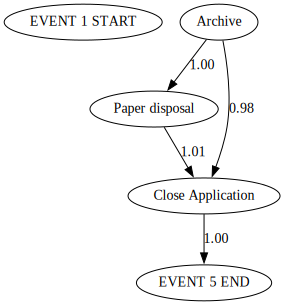

In [62]:
#Create the grapth from results of the alg run
import os
#On windows - update the path to Graphviz executables
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz/bin/'
make_dot(model.adjacency_matrix_, labels = list(new_df.columns))

### alpha on data

In [65]:
from datetime import timedelta 
df['Timestamp']= pd.to_datetime(df['Timestamp'])
df.loc[df["Source"] == "End Event", "Timestamp"] = df.loc[df["Source"] == "End Event", "Timestamp"] + timedelta(seconds=60)

In [66]:
eventlog = df.copy()
eventlog = eventlog[eventlog['Type']=='complete']
del eventlog['Type']

eventlog.rename(columns={'Timestamp': 'time:timestamp', 'Id': 'case:concept:name', 'Source': 'concept:name'}, inplace=True)

## Convert to log format
log = log_converter.apply(eventlog)

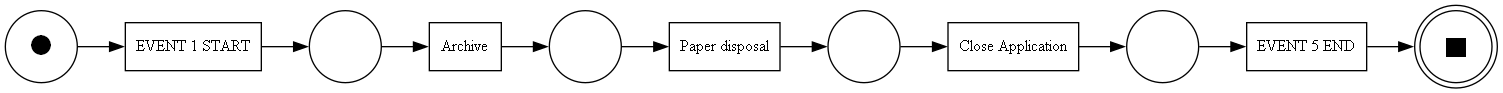

In [67]:
 # alpha miner
net, initial_marking, final_marking = alpha_miner.apply(log)

# Visualise
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)

### heuristic miner

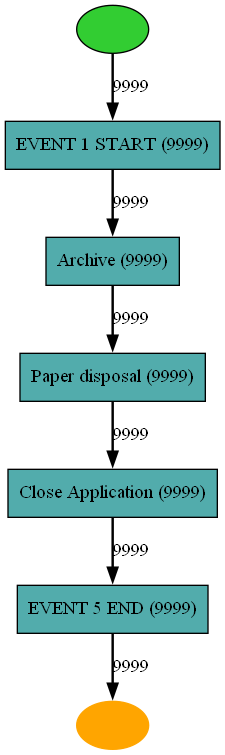

In [68]:
# heuristics miner
heu_net = heuristics_miner.apply_heu(log)

# viz
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)